In [1]:
from PIL import Image
import os
# data 
import numpy as np
# ML packages
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from tensorflow_addons.metrics import F1Score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# visualizations
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from skimage import filters

C:\Users\hetey\AppData\Local\R\cache\R\basilisk\112~1.1\0\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
data_dir = "../data/train/jpg/"
new_data_dir = "../data/test/jpg/"

In [3]:
input_shape = (240, 240)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,     
    rotation_range=20,
    horizontal_flip =True,
    vertical_flip = True ,
    fill_mode ='nearest'
)

train_generator = train_datagen.flow_from_directory(
    directory='../data/train/',
    target_size=input_shape,
    color_mode="rgb",
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    seed=42,
    subset='training'
)

class_labels = train_generator.classes
class_labels
class_weights = compute_class_weight('balanced' ,classes=np.unique(class_labels), y=class_labels)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

Found 511 images belonging to 2 classes.
{0: 0.9533582089552238, 1: 1.051440329218107}


In [7]:
def tiff_to_cnn_format(file_path, target_size=(240, 240), normalize=True, expand_dims=True):
    """
    Read a TIFF image and convert it to a format compatible with CNN pipelines.
    
    Args:
    file_path (str): Path to the TIFF file.
    target_size (tuple): Desired size of the output image (height, width).
    normalize (bool): If True, normalize pixel values to [0, 1].
    expand_dims (bool): If True, add a batch dimension.
    
    Returns:
    numpy.ndarray: Image array ready for CNN input.
    """
    
    # Check if file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    
    # Open the TIFF image
    with Image.open(file_path) as img:
        # Convert to RGB if it's not already
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Resize the image
        img = img.resize(target_size)
        
        # Convert to numpy array
        img_array = np.array(img)
        
        # Normalize if required
        if normalize:
            img_array = img_array.astype(np.float32) / 255.0
        
        # Add batch dimension if required
        if expand_dims:
            img_array = np.expand_dims(img_array, axis=0)
        
        return img_array

__Notes for the model:__

- Pre-trained model: MobileNetV2

Unfreezed layers: 
- deeper convolutional layers (Conv2D)
- Batch normalization layers

resource: [Unfreezing and Transfer Learning in Deep Learning](https://medium.com/@fakhar3534/unfreezing-and-transfer-learning-in-deep-learning-a31ef2ad9e8c)


Preparing data..
Splitting data..
Create model..
Fit model..
Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 0.7937 - f1_score: 0.5066 - accuracy: 0.5088
Epoch 1: val_loss improved from inf to 0.70386, saving model to best_cnn_model.h5


C:\Users\hetey\AppData\Local\R\cache\R\basilisk\112~1.1\0\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 33s 4s/step - loss: 0.7937 - f1_score: 0.5066 - accuracy: 0.5088 - val_loss: 0.7039 - val_f1_score: 0.5667 - val_accuracy: 0.3953 - lr: 4.5000e-05
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 0.6422 - f1_score: 0.5066 - accuracy: 0.6959
Epoch 2: val_loss improved from 0.70386 to 0.67519, saving model to best_cnn_model.h5
6/6 [==============================] - 23s 4s/step - loss: 0.6422 - f1_score: 0.5066 - accuracy: 0.6959 - val_loss: 0.6752 - val_f1_score: 0.5667 - val_accuracy: 0.6279 - lr: 4.5000e-05
Epoch 3/50
6/6 [==============================] - ETA: 0s - loss: 0.5156 - f1_score: 0.5066 - accuracy: 0.7544
Epoch 3: val_loss improved from 0.67519 to 0.66519, saving model to best_cnn_model.h5
6/6 [==============================] - 25s 4s/step - loss: 0.5156 - f1_score: 0.5066 - accuracy: 0.7544 - val_loss: 0.6652 - val_f1_score: 0.5667 - val_accuracy: 0.6047 - lr: 4.5000e-05
Epoch 4/50
6/6 [==============================] 

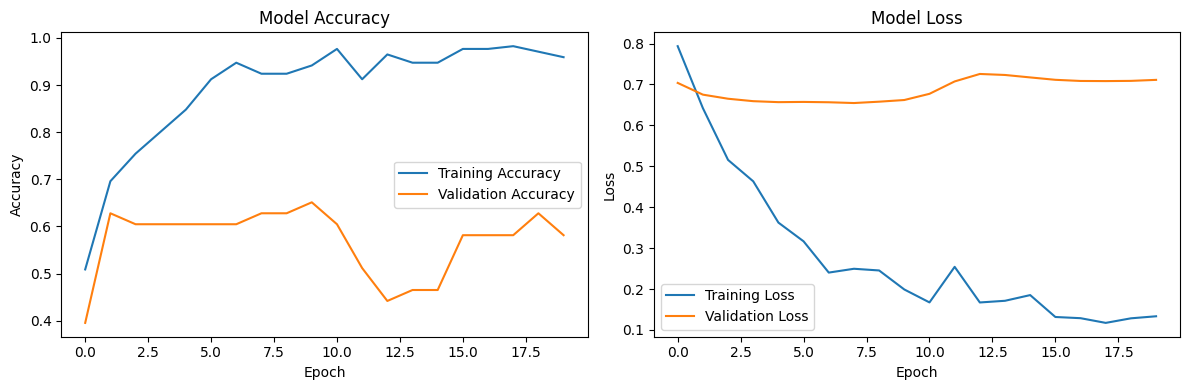

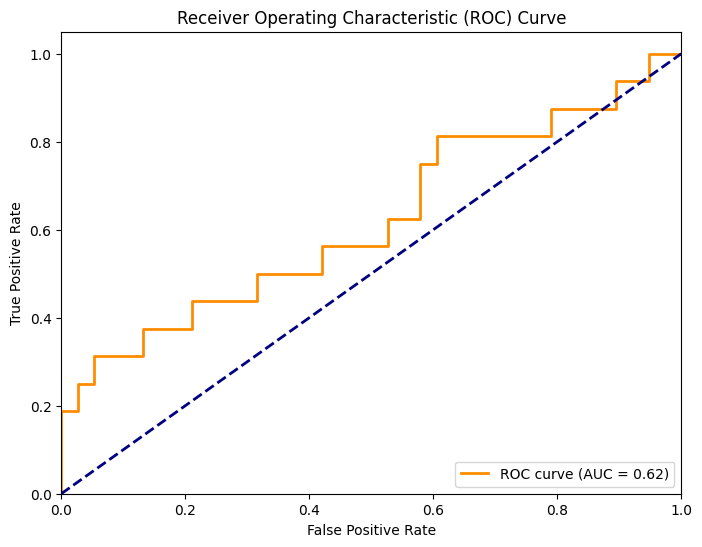

In [9]:
# Assume we have the tiff_to_cnn_format function from before
# from previous_code import tiff_to_cnn_format
def load_and_preprocess_data(data_dir):
    images = []
    labels = []
    classes = ['A', 'B']
    for class_id, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.jpg'):
                file_path = os.path.join(class_dir, filename)
                img = tiff_to_cnn_format(file_path)
                images.append(img)
                labels.append(class_id)
    
    return np.concatenate(images, axis=0), np.array(labels)

def create_binary_classification_model(input_shape):
    base_model = tf.keras.applications.ResNet101V2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
     # Freeze the convolutional base
    base_model.trainable = False 
    unfreeze_from_layer = ['conv5_block3_3_conv', 'conv5_block3_2_conv', 'conv5_block2_2_conv']
    set_trainable = False
    
    # un-freeze the BatchNorm layers
    for layer in base_model.layers:
       if "BatchNormalization" in layer.__class__.__name__:
            layer.trainable = True

    # un-freeze the deeper Conv2D layers
    for layer in base_model.layers:
        if layer.name in unfreeze_from_layer:
            set_trainable = True
        if set_trainable:
            layer.trainable = True

    # add custom layers
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

def plot_accuracy_vs_epoch(history):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    return plt.gcf()

def plot_training_history(history):
    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    return fig

def plot_roc_curve(y_true, y_pred):
    fig = plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    return fig

# Main workflow
def main():
    # Parameters
    input_shape = (240, 240, 3)  # Adjust based on your image size
    batch_size = 32
    epochs = 50

    # Load and preprocess data
    print("Preparing data..")
    X, y = load_and_preprocess_data(data_dir)
    
    # Split the data
    print("Splitting data..")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create the model
    print("Create model..")
    model = create_binary_classification_model(input_shape)

    # Compile the model
    def lr_schedule(epoch):
        initial_lr = 4.5e-5
        decrease_factor = 1.5    
        if epoch >= 8:
            return initial_lr / (decrease_factor * (epoch // 8))
        return initial_lr

    lr_scheduler = LearningRateScheduler(lr_schedule)
    optimizer = tf.keras.optimizers.Adam()
    checkpoint = ModelCheckpoint('best_cnn_model.h5', save_best_only=True, verbose=1)
    early_stopping = EarlyStopping(patience=12, restore_best_weights=True)
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[F1Score(num_classes=2, average='micro'), 'accuracy'])

    # Train the model
    print("Fit model..")
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                        validation_split=0.2, verbose=1, 
                        callbacks=[lr_scheduler, checkpoint, early_stopping], 
                        class_weight = class_weight_dict)

    # Evaluate the model
    test_loss, test_acc, test_f1 = model.evaluate(X_test, y_test, verbose=2)
    print(f'\nTest accuracy: {test_acc}\nTest F1: {test_f1}')

    # Plot training history
    plot_training_history(history)
        
    # Calculate and plot ROC curve
    print("Predicting..")
    y_pred = model.predict(X_test).ravel()    
    plot_roc_curve(y_test, y_pred)

    with PdfPages('cnn_model_evaluation_plots.pdf') as pdf:
        # Training history plots
        history_fig = plot_training_history(history)
        pdf.savefig(history_fig)
        plt.close(history_fig)
        
        # Accuracy vs Epoch plot
        acc_epoch_fig = plot_accuracy_vs_epoch(history)
        pdf.savefig(acc_epoch_fig)
        plt.close(acc_epoch_fig)
        
        # ROC curve
        y_pred = model.predict(X_test).ravel()
        roc_fig = plot_roc_curve(y_test, y_pred)
        pdf.savefig(roc_fig)
        plt.close(roc_fig)

    # Make predictions on new data
    new_images = []
    file_paths = []
    for filename in os.listdir(new_data_dir):
        if filename.endswith('.jpg'):
            file_path = os.path.join(new_data_dir, filename)
            file_paths.append(file_path)
            img = tiff_to_cnn_format(file_path)
            new_images.append(img)
    
    new_images = np.concatenate(new_images, axis=0)
    predictions = model.predict(new_images)
    
    for i, pred in enumerate(predictions):
        class_name = 'A' if pred[0] < 0.5 else 'B'
        confidence = pred[0] if class_name == 'B' else 1 - pred[0]
        print(f"File: {file_paths[i]} - Image {i+1}: Class {class_name} (Confidence: {confidence:.2f})")

if __name__ == "__main__":
    main()